In [3]:
import os
import pickle
from PIL import Image
import random
import re

import nltk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import fa2

from datautils import datautils
from graph import graph
from sentiment import sentiment

from wordcloud import WordCloud
from style import style

import numpy as np

In [4]:
if os.path.exists('data/data_all.pickle'):
    with open('data/data_all.pickle', "rb") as rbfile:
        data = pickle.load(rbfile)
else:
    loader = datautils.Loader()
    loader.load("data/characters/")
    data = loader.to_dataframe()
    loader.drop()

In [5]:
GRAPH_PATH_EPISODES = 'graph/universe_episodes.pickle'
FA_POSITIONS = "graph/fa_positions.pickle"
# POSITIONS_COMMUNITIES = "graph/positions_communities.pickle"

## Analyze only universe based on canonical movies

In [6]:
episodes = [
    "Star_Wars:_Episode_I_The_Phantom_Menace",
    "Star_Wars:_Episode_II_Attack_of_the_Clones",
    "Star_Wars:_Episode_III_Revenge_of_the_Sith",
    "Star_Wars:_Episode_IV_A_New_Hope",
    "Star_Wars:_Episode_V_The_Empire_Strikes_Back",
    "Star_Wars:_Episode_VI_Return_of_the_Jedi",
    "Star_Wars:_Episode_VII_The_Force_Awakens",
    "Star_Wars:_Episode_VIII_The_Last_Jedi",
    "Star_Wars:_Episode_IX_The_Rise_of_Skywalker",
]

characters_in_episodes = []

for _, char in data.iterrows():
    # iterate over records
    for crosslink in char.Crosslinks:
        if crosslink in episodes:
            # append only characters which have crosslink to one of the episodes
            characters_in_episodes.append(char.Name)
            break

episodes_characters_data = data.loc[data['Name'].isin(characters_in_episodes)]
episodes_characters_data.head()

Name          DisplayName  \
5                 1047                 1047   
7   1138_(First_Order)  1138  (First Order)   
28               4/163                4/163   
30               5/373                5/373   
32               6/298                6/298   

                                              Content  \
5   1047 was a Human male stormtrooper who served ...   
7   1138 was a human male stormtrooper who served ...   
28  CT-4/163 was a clone trooper in the Grand Army...   
30  5/373 was a clone trooper in the Grand Army of...   
32  6/298 was a clone trooper in the Grand Army of...   

                                           Crosslinks Species Gender  \
5   [Star_Wars_Legends, Wookieepedia:Good_articles...   Human   Male   
7   [Canon, 1138, Special:Upload, Human, Gender, F...   Human   Male   
28  [Star_Wars_Legends, Kamino/Legends, Human/Lege...   Human   Male   
30  [Star_Wars_Legends, Wookieepedia:Sourcing, Spe...   Human   Male   
32  [Star_Wars_Legends, Kamino/Legends, 32_BBY/Leg...   Human   Male   

                                       Affiliation(s) Homeworld Died  
5     [Galactic Empire, Zeta Squadron, Zeta Squadron]       NaN  NaN  
7   [First Order, Stormtrooper Corps, Stormtrooper...       NaN  NaN  
28  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN  
30  [Galactic RepublicGrand Army of the Republic, ...    Kamino  NaN  
32  [Galactic Republic, Grand Army of the Republic...    Kamino  NaN

In [7]:
if os.path.exists(GRAPH_PATH_EPISODES):
    with open(GRAPH_PATH_EPISODES, 'rb') as f:
        universe_episodes = pickle.load(f)
else:
    universe_episodes = graph.create_directed_graph(episodes_characters_data)

    with open(GRAPH_PATH_EPISODES, 'wb') as f:
        pickle.dump(universe_episodes, f)

==================== Universe stats ====================

In degree: {'mean': 4.605247641509434, 'median': 1.0, 'mode': 0, 'min': 0, 'max': 450}
Out degree: {'mean': 4.605247641509434, 'median': 2.0, 'mode': 0, 'min': 0, 'max': 190}
Number of nodes: 3392
Number of edges: 15621
==================== Largest connected component stats ====================

Number of nodes: 2276
Number of edges: 10438


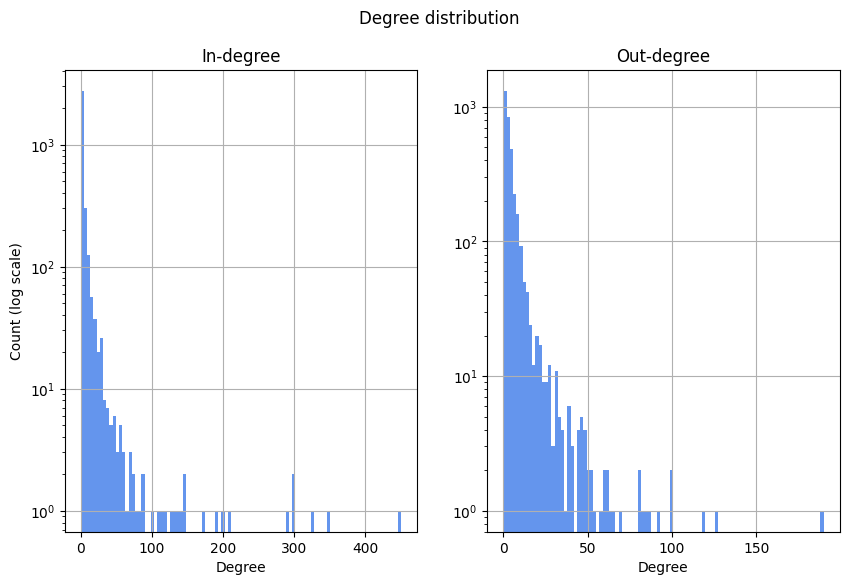

In [8]:
style.print_header("Universe stats")
print(f"In degree: {graph.calc_stats(universe_episodes.in_degree())}")
print(f"Out degree: {graph.calc_stats(universe_episodes.out_degree())}")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")
_ = graph.plot_degree_distribution(universe_episodes, scale="log")

# Get the largest connected component and transform to undirected graph
universe_episodes = graph.connected_components(universe_episodes)
universe_episodes = universe_episodes.to_undirected()

style.print_header("Largest connected component stats")
print(f"Number of nodes: {len(universe_episodes.nodes)}")
print(f"Number of edges: {len(universe_episodes.edges)}")

<AxesSubplot: title={'center': 'Star Wars connections graph all episodes'}>

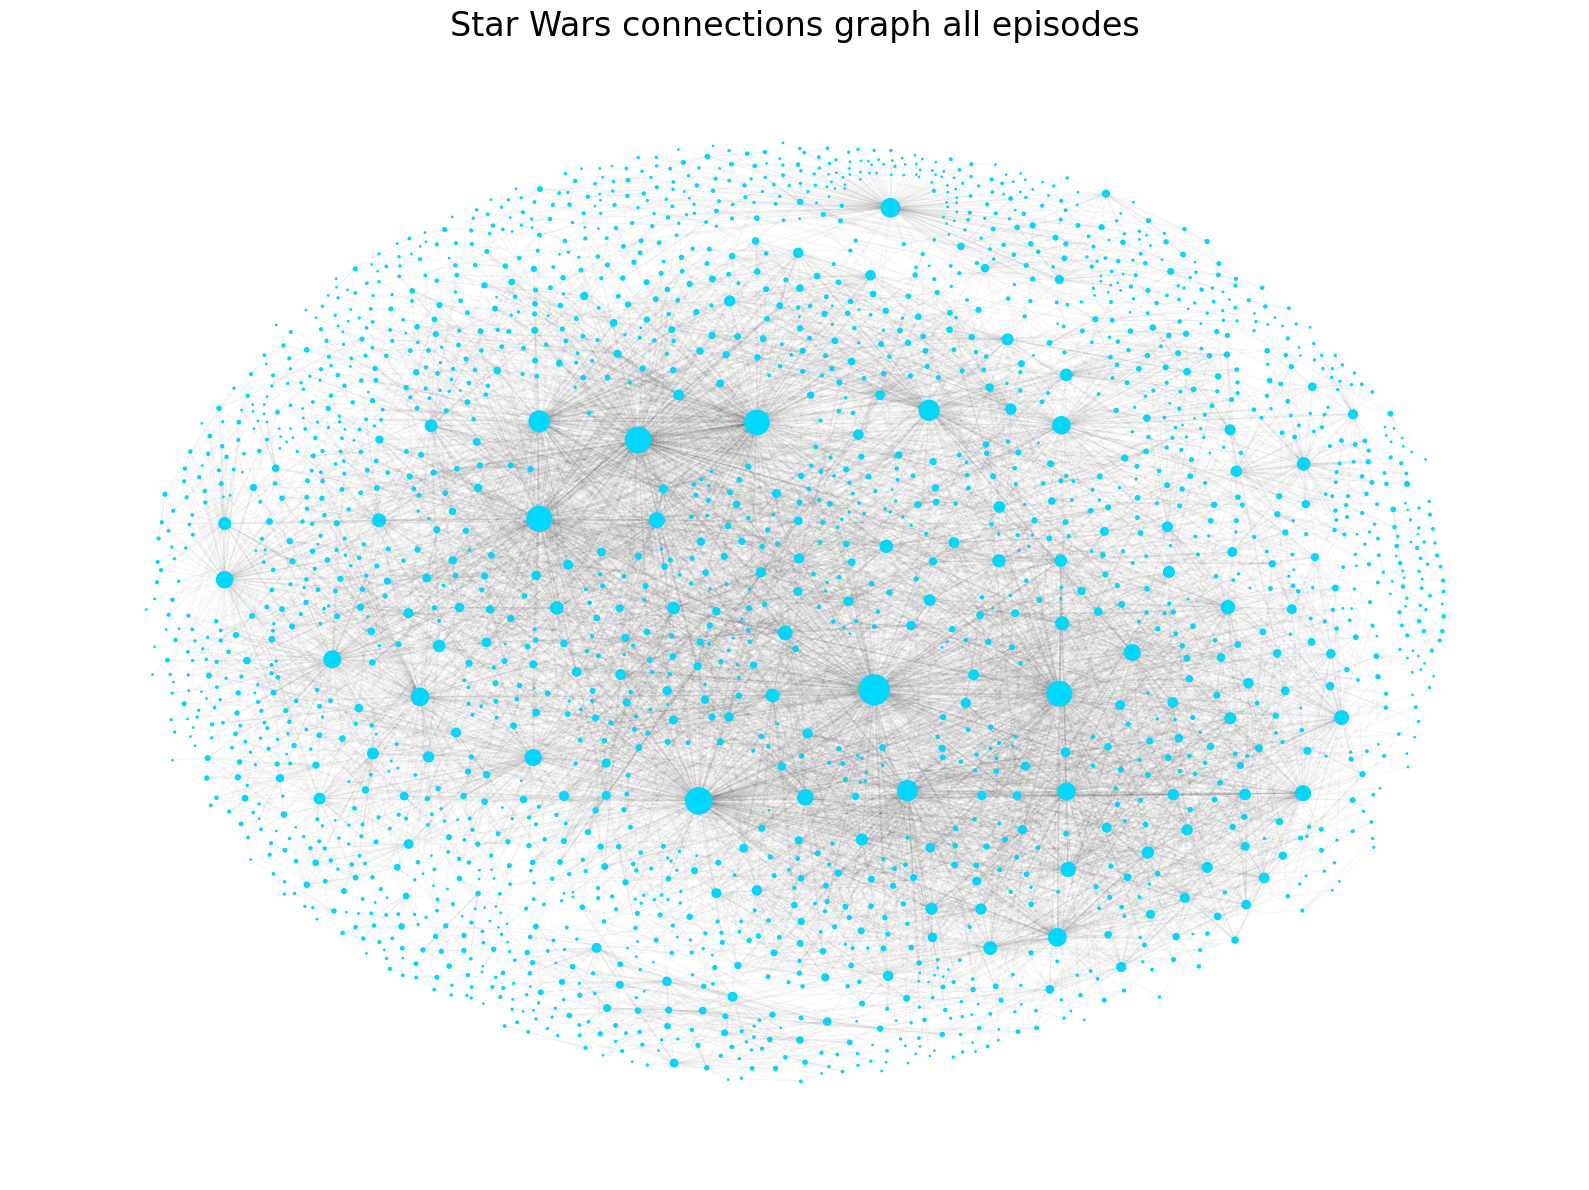

In [9]:
# use Force Atlas 2
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2(strongGravityMode=True).forceatlas2_networkx_layout(universe_episodes, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Star Wars connections graph all episodes",
    node_alpha=1,
    edge_alpha=0.033,
    figsize=(16, 12),
)

### Finding communities

Graph modularity 0.56


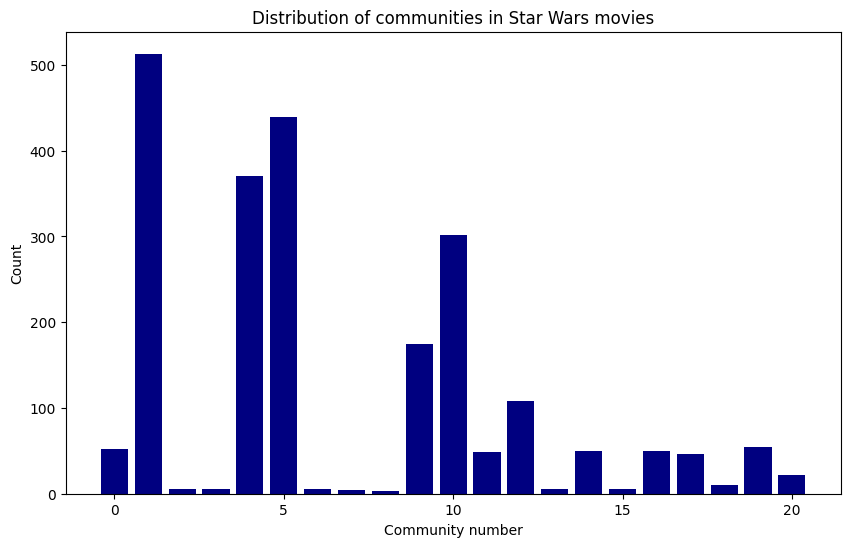

In [10]:
# find communities and its properties
partition, communities, mod = graph.find_communities(universe_episodes)
most_comm_communities = communities.most_common(10)
print(f"Graph modularity {mod:.2f}")
graph.plot_distribution(
    communities.keys(),
    communities.values(),
    title="Distribution of communities in Star Wars movies",
    xlabel="Community number",
)

In [11]:
top_characters_in_community = [""] * len(communities)

for name, community_no in partition.items():
    character = top_characters_in_community[community_no]
    if not character or universe_episodes.degree(name) > universe_episodes.degree(character):
       top_characters_in_community[community_no] = name

labels = [(name, style.initials(data[data.Name == name].DisplayName.values[0])) for name in top_characters_in_community]
mapping = {name: data[data.Name == name].DisplayName.values[0] for name in top_characters_in_community}

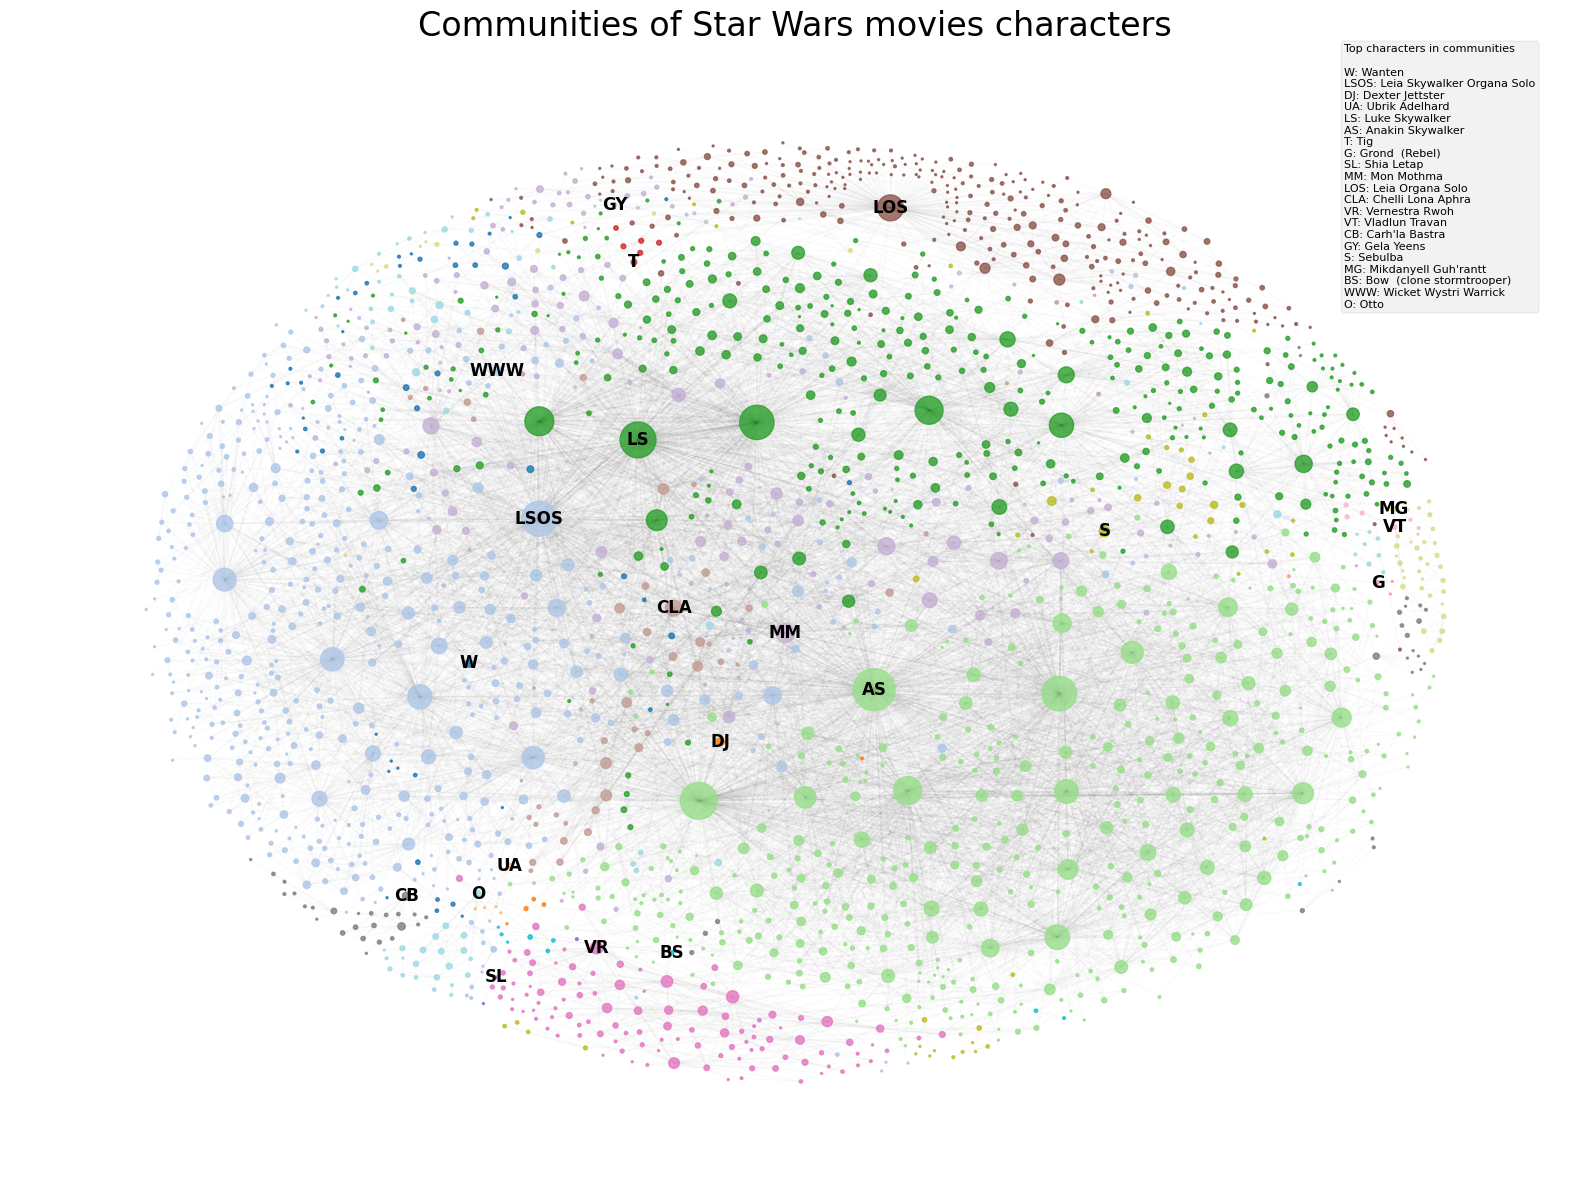

In [12]:
# node_degrees = sorted(universe_episodes.degree, key=lambda x: x[1], reverse=True)
# labels = [(name[0], data[data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:10]]

cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
ax = graph.plot_graph_with_positons(
    universe_episodes,
    positions,
    "Communities of Star Wars movies characters",
    figsize=(16, 12),
    node_color=list(partition.values()),
    cmap=cmap,
    node_size_factor=2,
    labels=dict(labels),
    edge_alpha=0.02,
    label_font_size=12
)

props = dict(boxstyle="round", facecolor=style.Color.BLACK, alpha=0.05)

text_initials = "\n".join(
    f"{initials}: {mapping[name]}" for (name, initials) in labels
)
text_initials = "Top characters in communities\n\n" + text_initials
ax.text(0.85, 1, text_initials, transform=ax.transAxes, fontsize=8, verticalalignment="top", bbox=props);

Number of nodes per community

In [13]:
for community_no, nodes_no in communities.items():
    print(f"Community {community_no:4d}, nodes: {nodes_no:4d}, largest hub: {mapping[top_characters_in_community[community_no]]}")

Community    0, nodes:   52, largest hub: Wanten
Community    1, nodes:  513, largest hub: Leia Skywalker Organa Solo
Community    4, nodes:  370, largest hub: Luke Skywalker
Community    5, nodes:  439, largest hub: Anakin Skywalker
Community    9, nodes:  175, largest hub: Mon Mothma
Community   10, nodes:  302, largest hub: Leia Organa Solo
Community   12, nodes:  108, largest hub: Vernestra Rwoh
Community   11, nodes:   49, largest hub: Chelli Lona Aphra
Community   16, nodes:   50, largest hub: Sebulba
Community   17, nodes:   46, largest hub: Mikdanyell Guh'rantt
Community   19, nodes:   55, largest hub: Wicket Wystri Warrick
Community   14, nodes:   50, largest hub: Carh'la Bastra
Community   13, nodes:    6, largest hub: Vladlun Travan
Community   15, nodes:    5, largest hub: Gela Yeens
Community   18, nodes:   10, largest hub: Bow  (clone stormtrooper)
Community   20, nodes:   22, largest hub: Otto
Community    2, nodes:    6, largest hub: Dexter Jettster
Community    3, node

## Generate Word Cloud from Term Frequency

In [14]:
# calculate term frequency for characters that occur in Episodes
tokens = (token for text in episodes_characters_data.Content for token in nltk.word_tokenize(text))
tokens = sentiment.SentimentAnalyzer.normalize_text(tokens)

term_freqs = sentiment.term_freq(tokens)

In [15]:
# calculate inverse term freq for all texts
texts = [sentiment.SentimentAnalyzer.normalize_text(nltk.word_tokenize(content)) for content in data.Content]
idf = sentiment.inv_doc_freq(texts)

In [16]:
tfidf = {}
for term, freq in term_freqs.items():
    tfidf[term] = freq * idf.get(term, 1)

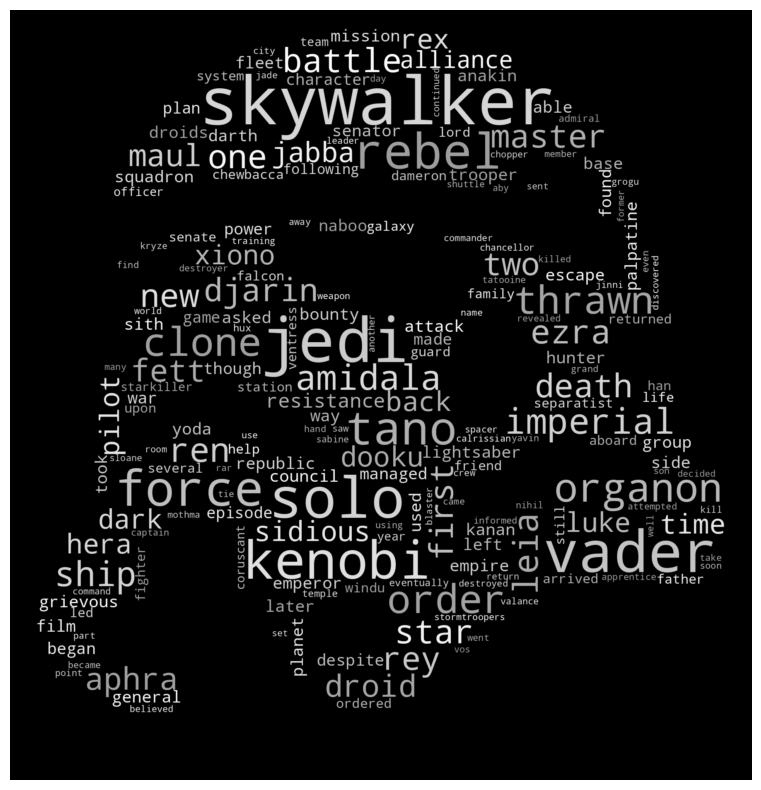

In [17]:
# visualize words in a storm trooper style
mask = 255 - np.array(Image.open("images/stormtrooper.png"))
def _grey_color_func(
    word,
    font_size,
    position,
    orientation,
    random_state=None,
    **kwargs,
):
    return f"hsl(0, 0%, {random.randint(60, 100):d}%)"

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
wordcloud = WordCloud(
    collocations=False,
    background_color="black",
    colormap="inferno",
    height=1024,
    mask=mask,
).generate_from_frequencies(tfidf)

ax.imshow(wordcloud.recolor(color_func=_grey_color_func), interpolation="bilinear")
ax.axis("off")
plt.show()

## Communities for separate movies

Number of characters in movie 1: 366
Number of characters in movie 2: 423
Number of characters in movie 3: 409
Number of characters in movie 4: 1467
Number of characters in movie 5: 372
Number of characters in movie 6: 538


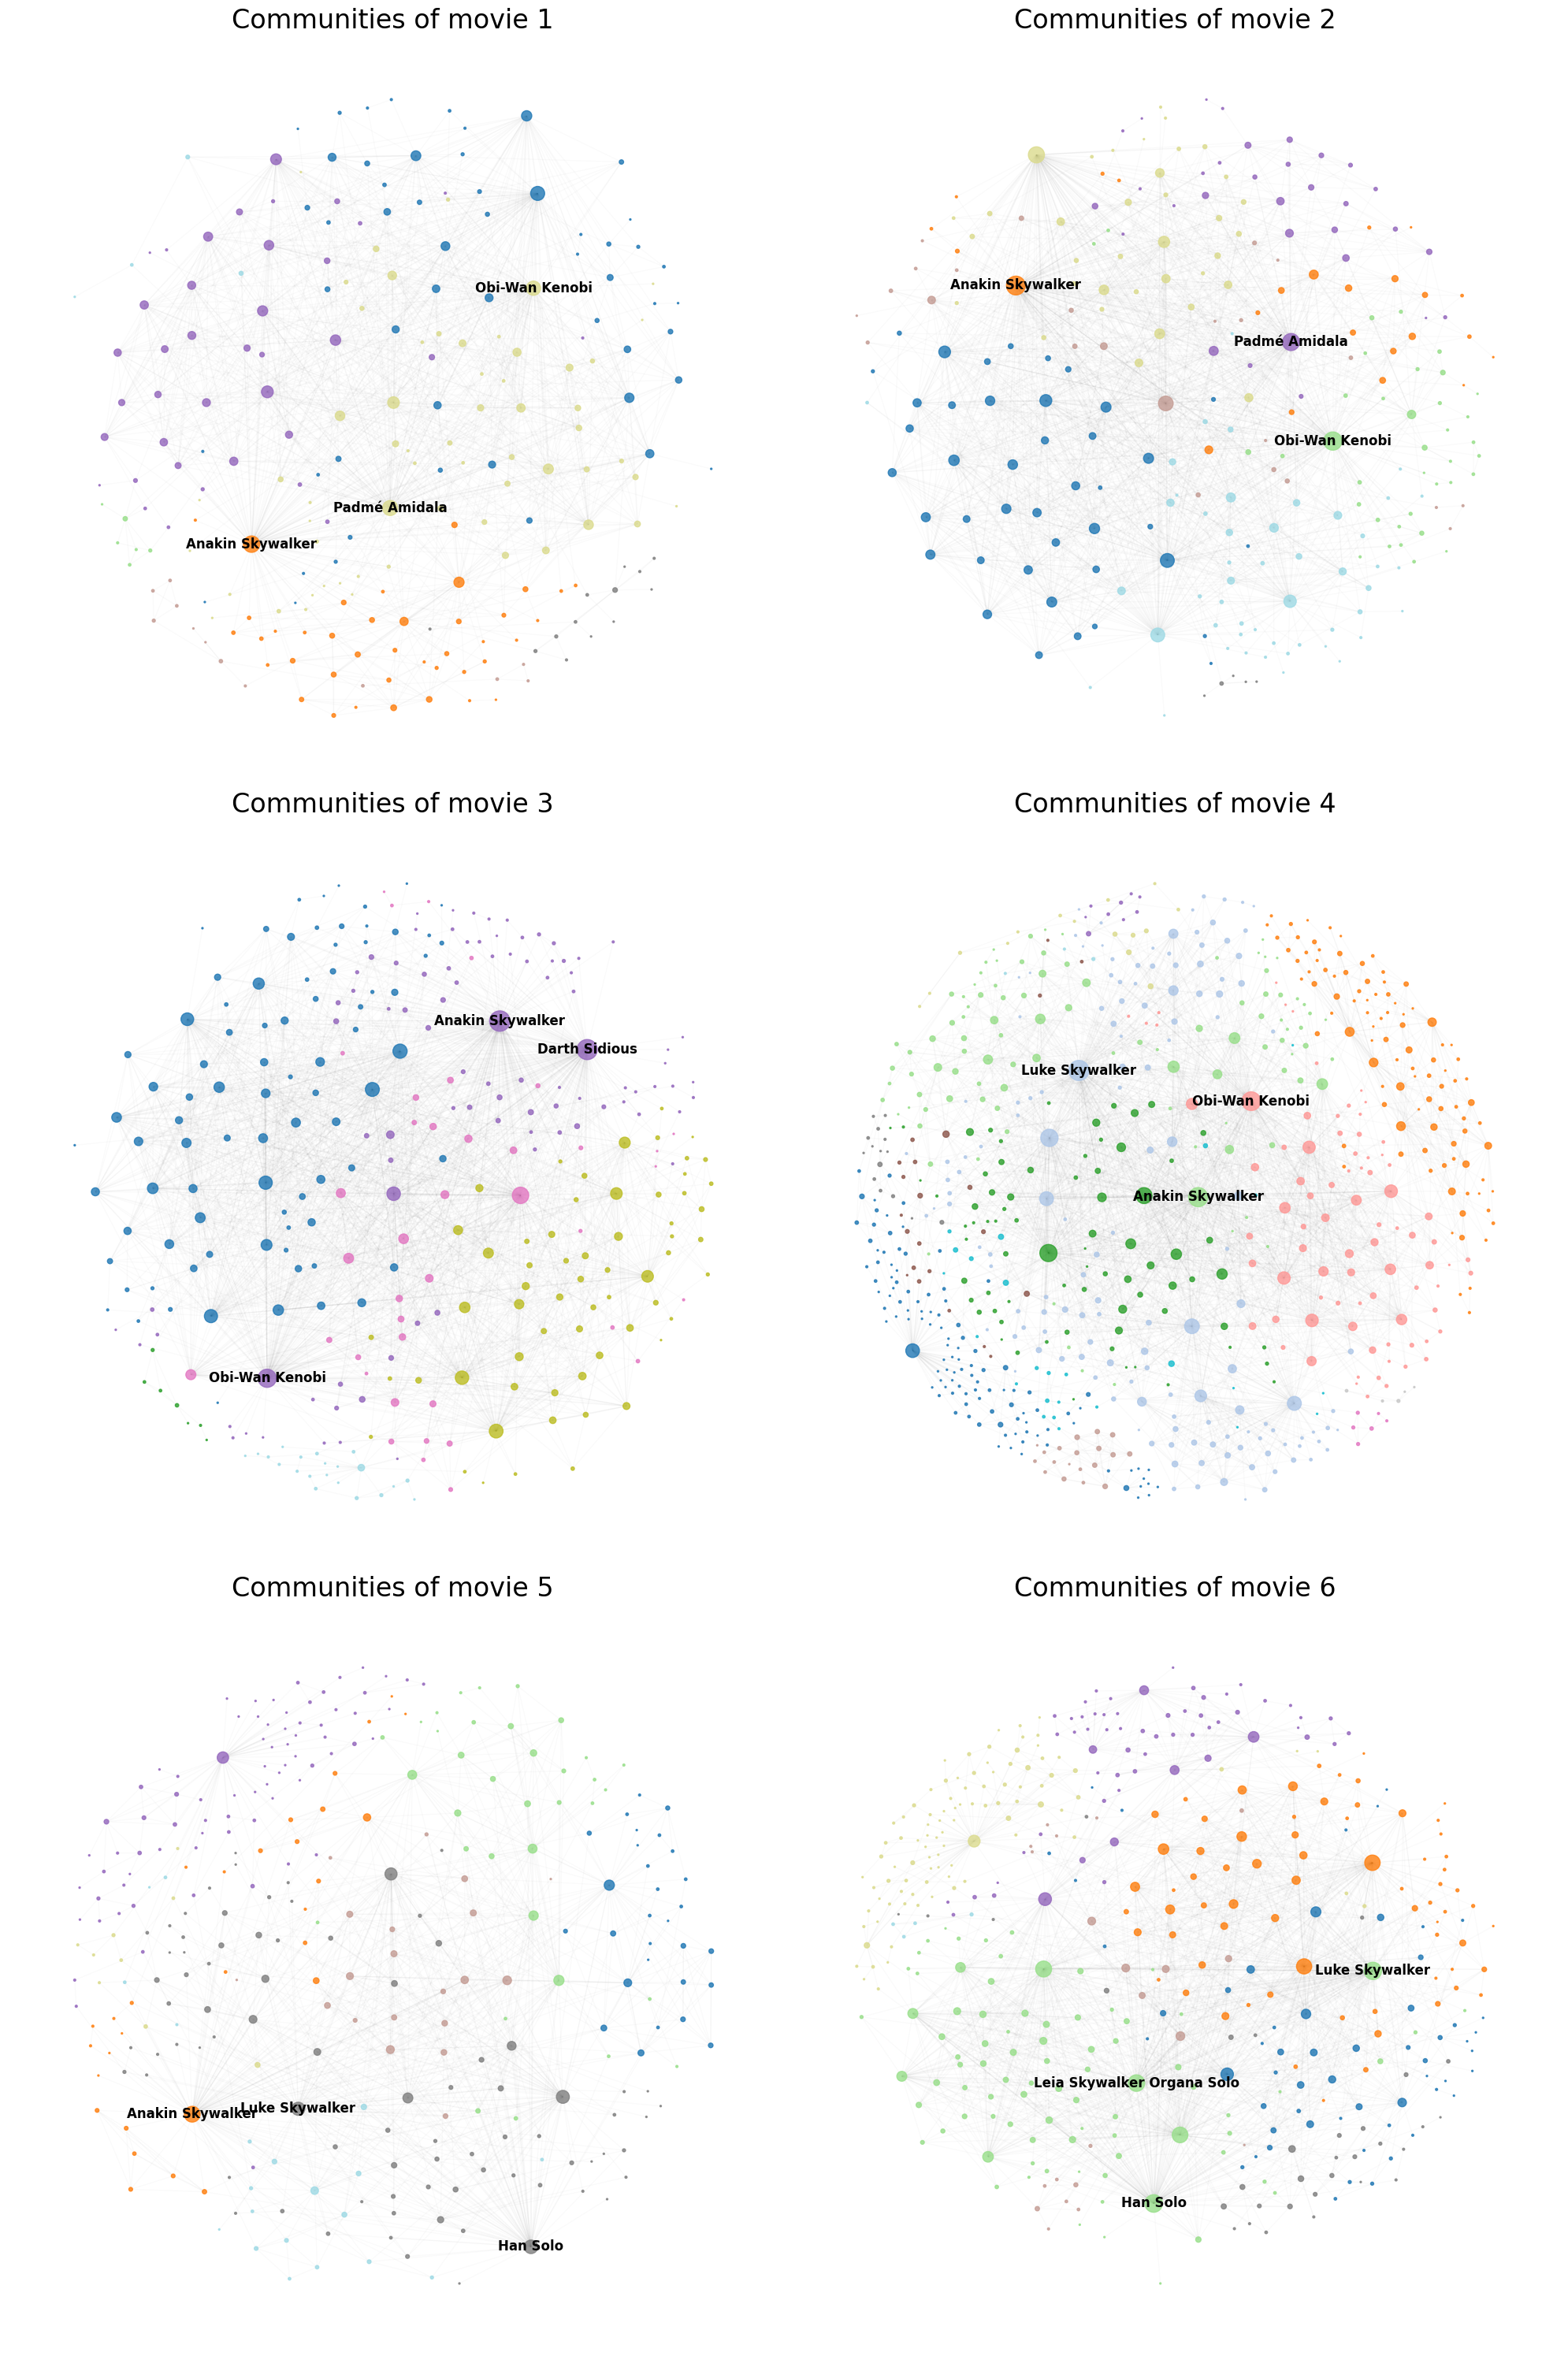

In [15]:
fig, ax = plt.subplots(3,2, figsize = (20,30))

fa_positions_path_tmpl= "graph/fa_positions_ep{}"
for i in range(6):
    # find characters from matching episode
    characters_in_episodes = datautils.find_rows_with(episodes[i], data, lookup_column="Crosslinks", match_column="Name")
    # filter dataframe with found characters
    episode_data = data.loc[data['Name'].isin(characters_in_episodes)] 

    print(f'Number of characters in movie {i + 1}: {len(episode_data)}')

    # calculate largest connected component
    episode_graph = graph.connected_components(graph.create_directed_graph(episode_data)).to_undirected()

    fa_positions_path = fa_positions_path_tmpl.format(i+1)
    if os.path.exists(fa_positions_path):
        # load positions if they already exist for consistency
        with open(fa_positions_path, "rb") as rbfile:
            positions_episode = pickle.load(rbfile)
    else:
        # calculate graph positions for an undirected graph
        positions_episode = fa2.ForceAtlas2(
            strongGravityMode=True,
            verbose=False
        ).forceatlas2_networkx_layout(episode_graph, pos=None, iterations=2000)
        # save positions for later use
        with open(fa_positions_path, "wb") as wbfile:
            pickle.dump(positions_episode, wbfile)

    # find communities and its properties
    partition, communities, mod = graph.find_communities(episode_graph)
    # use tab20 colormap
    cmap = cm.get_cmap("tab20", max(partition.values()) + 1)
    # add labels for three largest hubs
    node_degrees = sorted(episode_graph.degree, key=lambda x: x[1], reverse=True)
    labels = [(name[0], episode_data[episode_data.Name == name[0]].DisplayName.values[0]) for name in node_degrees[:3]]

    graph.plot_graph_with_positons(
        episode_graph,
        positions_episode,
        f"Communities of movie {i+1}",
        node_color=list(partition.values()),
        cmap=cmap,
        node_size_factor=2,
        edge_alpha=0.02,
        label_font_size=12,
        ax=ax[int(np.floor(i/2)), i%2],
        labels=dict(labels)
        )
plt.show()